In [45]:
import os
import torch
from numpy import dtype
from torch.utils.data import Dataset, DataLoader
import numpy as np

import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.model_selection import train_test_split

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

data_dir = '/home/avp/TRex/data'

# A. Generate Data

In [46]:
#!Rscript generate_data.R --N_data=10000

# B. Train Model

In [47]:
class PhiThreshDataset(Dataset):
    def __init__(self, data_dir):
        self.phi_dir = os.path.join(data_dir, 'Phi_mat')
        self.beta_dir = os.path.join(data_dir, 'beta')
        self.v_dir = os.path.join(data_dir, 'v')
        self.FDR_dir = os.path.join(data_dir, 'FDR')
        
        self.phi_files = [f for f in os.listdir(self.phi_dir) if f.startswith('Phi_mat_') and f.endswith('.txt')]
        self.beta_files = [f for f in os.listdir(self.beta_dir) if f.startswith('beta_') and f.endswith('.txt')]
        self.v_files = [f for f in os.listdir(self.v_dir) if f.startswith('v_') and f.endswith('.txt')]
        self.FDR_files = [f for f in os.listdir(self.FDR_dir) if f.startswith('FDR_') and f.endswith('.txt')]

    def __len__(self):
        return len(self.phi_files)

    def __getitem__(self, idx):
        phi_file = os.path.join(self.phi_dir, self.phi_files[idx])
        phi = np.loadtxt(phi_file)

        beta_file = os.path.join(self.beta_dir, self.beta_files[idx])
        beta = np.loadtxt(beta_file)
        
        v_file = os.path.join(self.v_dir, self.v_files[idx])
        v = np.loadtxt(v_file)
        
        FDR_file = os.path.join(self.FDR_dir, self.FDR_files[idx])
        FDR = np.loadtxt(FDR_file)

        return torch.tensor(phi, dtype=torch.float32), torch.tensor(beta, dtype=torch.float32), torch.tensor(v, dtype=torch.float32), torch.tensor(FDR, dtype=torch.float32)

In [48]:
def get_data_loaders(data_dir, batch_size=32, test_size=0.2):
    dataset = PhiThreshDataset(data_dir)
    train_indices, test_indices = train_test_split(list(range(len(dataset))), test_size=test_size, random_state=42)
    
    train_set = torch.utils.data.Subset(dataset, train_indices)
    test_set = torch.utils.data.Subset(dataset, test_indices)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, train_indices, test_indices

In [49]:
class PhiNet(nn.Module):
    def __init__(self, input_size):
        super(PhiNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 8)
        self.fc4 = nn.Linear(8, 1)
        
    def forward(self, Phi, v):
        v = v.unsqueeze(1)
        x = torch.cat((Phi, v), dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

In [50]:
def sigma_v(x, v, exponent=10):
    v = v.view(-1, 1)
    return 1 / (1 + torch.exp(-exponent * (x - v)))

def FDR_surr(v, Phi, beta):
    return torch.sum(sigma_v((1 - beta) * Phi, v), dim=1) / torch.sum(sigma_v(Phi, v), dim=1)

In [51]:
def evaluate_model(model, train_loader, test_loader, criterion, verbose=True, device=device):
    model.eval()
    losses_over_train = []
    with torch.no_grad():
        for Phis, betas, vs, FDRs in train_loader:
            Phis, betas, vs, FDRs = Phis.to(device), betas.to(device), vs.to(device), FDRs.to(device)
            outputs = model(Phis, vs)
            loss = criterion(outputs, FDRs.unsqueeze(1))
            losses_over_train.append(loss.item())
    if verbose:
        print(f'Train Loss: {sum(losses_over_train) / len(train_loader):.4f}')
    
    losses_over_test = []
    with torch.no_grad():
        for Phis, betas, vs, FDRs in test_loader:
            Phis, betas, vs, FDRs = Phis.to(device), betas.to(device), vs.to(device), FDRs.to(device)
            outputs = model(Phis, vs)
            loss = criterion(outputs, FDRs.unsqueeze(1))
            losses_over_test.append(loss.item())
    if verbose:
        print(f'Test Loss: {sum(losses_over_test) / len(test_loader):.4f}')
    
    return losses_over_train, losses_over_test

def train_model(model, train_loader, criterion, optimizer, num_epochs=10, device=device):
    model.train()
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", position=0)
        for _, (Phis, betas, vs, FDRs) in progress_bar:
            Phis, betas, vs, FDRs = Phis.to(device), betas.to(device), vs.to(device), FDRs.to(device)
            optimizer.zero_grad()
            outputs = model(Phis, vs)
            loss = criterion(outputs, FDRs.unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Running Loss: {running_loss / len(train_loader):.4f}')
        losses_over_train, losses_over_test = evaluate_model(model, train_loader, test_loader, criterion)
        train_losses.append(sum(losses_over_train) / len(train_loader))
        test_losses.append(sum(losses_over_test) / len(test_loader))
    return train_losses, test_losses

In [52]:
input_size = len(np.loadtxt(os.path.join(data_dir, 'Phi_mat/Phi_mat_1.txt'))) + 1

hparams = {"batch_size": 16,
           "learning_rate": 0.001,
           "num_epochs": 100}

train_loader, test_loader, train_indices, test_indices = get_data_loaders(data_dir, batch_size=hparams["batch_size"])

model = PhiNet(input_size=input_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=hparams["learning_rate"])

train_losses, test_losses = train_model(model, train_loader, criterion, optimizer, num_epochs=hparams["num_epochs"], device=device)

Epoch 1/100: 100%|██████████| 500/500 [00:02<00:00, 167.47it/s]


Epoch [1/100], Running Loss: 0.0445
Train Loss: 0.0223
Test Loss: 0.0225


Epoch 2/100: 100%|██████████| 500/500 [00:02<00:00, 170.44it/s]


Epoch [2/100], Running Loss: 0.0207
Train Loss: 0.0174
Test Loss: 0.0186


Epoch 3/100: 100%|██████████| 500/500 [00:02<00:00, 167.67it/s]


Epoch [3/100], Running Loss: 0.0159
Train Loss: 0.0141
Test Loss: 0.0160


Epoch 4/100: 100%|██████████| 500/500 [00:02<00:00, 172.20it/s]


Epoch [4/100], Running Loss: 0.0146
Train Loss: 0.0135
Test Loss: 0.0158


Epoch 5/100: 100%|██████████| 500/500 [00:02<00:00, 172.15it/s]


Epoch [5/100], Running Loss: 0.0139
Train Loss: 0.0131
Test Loss: 0.0165


Epoch 6/100: 100%|██████████| 500/500 [00:02<00:00, 171.54it/s]


Epoch [6/100], Running Loss: 0.0134
Train Loss: 0.0121
Test Loss: 0.0159


Epoch 7/100: 100%|██████████| 500/500 [00:02<00:00, 171.26it/s]


Epoch [7/100], Running Loss: 0.0126
Train Loss: 0.0114
Test Loss: 0.0159


Epoch 8/100: 100%|██████████| 500/500 [00:02<00:00, 171.35it/s]


Epoch [8/100], Running Loss: 0.0119
Train Loss: 0.0107
Test Loss: 0.0161


Epoch 9/100: 100%|██████████| 500/500 [00:02<00:00, 170.68it/s]


Epoch [9/100], Running Loss: 0.0112
Train Loss: 0.0101
Test Loss: 0.0165


Epoch 10/100: 100%|██████████| 500/500 [00:02<00:00, 170.69it/s]


Epoch [10/100], Running Loss: 0.0106
Train Loss: 0.0095
Test Loss: 0.0173


Epoch 11/100: 100%|██████████| 500/500 [00:02<00:00, 171.80it/s]


Epoch [11/100], Running Loss: 0.0100
Train Loss: 0.0090
Test Loss: 0.0169


Epoch 12/100: 100%|██████████| 500/500 [00:03<00:00, 164.09it/s]


Epoch [12/100], Running Loss: 0.0093
Train Loss: 0.0084
Test Loss: 0.0194


Epoch 13/100: 100%|██████████| 500/500 [00:02<00:00, 169.67it/s]


Epoch [13/100], Running Loss: 0.0086
Train Loss: 0.0073
Test Loss: 0.0186


Epoch 14/100: 100%|██████████| 500/500 [00:02<00:00, 169.90it/s]


Epoch [14/100], Running Loss: 0.0079
Train Loss: 0.0066
Test Loss: 0.0193


Epoch 15/100: 100%|██████████| 500/500 [00:02<00:00, 169.79it/s]


Epoch [15/100], Running Loss: 0.0071
Train Loss: 0.0062
Test Loss: 0.0201


Epoch 16/100: 100%|██████████| 500/500 [00:02<00:00, 167.47it/s]


Epoch [16/100], Running Loss: 0.0066
Train Loss: 0.0056
Test Loss: 0.0211


Epoch 17/100: 100%|██████████| 500/500 [00:02<00:00, 168.61it/s]


Epoch [17/100], Running Loss: 0.0059
Train Loss: 0.0052
Test Loss: 0.0207


Epoch 18/100: 100%|██████████| 500/500 [00:02<00:00, 170.50it/s]


Epoch [18/100], Running Loss: 0.0054
Train Loss: 0.0048
Test Loss: 0.0218


Epoch 19/100: 100%|██████████| 500/500 [00:02<00:00, 168.31it/s]


Epoch [19/100], Running Loss: 0.0051
Train Loss: 0.0043
Test Loss: 0.0213


Epoch 20/100: 100%|██████████| 500/500 [00:03<00:00, 166.35it/s]


Epoch [20/100], Running Loss: 0.0047
Train Loss: 0.0041
Test Loss: 0.0211


Epoch 21/100: 100%|██████████| 500/500 [00:02<00:00, 167.96it/s]


Epoch [21/100], Running Loss: 0.0044
Train Loss: 0.0038
Test Loss: 0.0213


Epoch 22/100: 100%|██████████| 500/500 [00:02<00:00, 171.05it/s]


Epoch [22/100], Running Loss: 0.0041
Train Loss: 0.0035
Test Loss: 0.0220


Epoch 23/100: 100%|██████████| 500/500 [00:02<00:00, 171.41it/s]


Epoch [23/100], Running Loss: 0.0038
Train Loss: 0.0036
Test Loss: 0.0229


Epoch 24/100: 100%|██████████| 500/500 [00:03<00:00, 165.96it/s]


Epoch [24/100], Running Loss: 0.0037
Train Loss: 0.0034
Test Loss: 0.0225


Epoch 25/100: 100%|██████████| 500/500 [00:02<00:00, 168.96it/s]


Epoch [25/100], Running Loss: 0.0036
Train Loss: 0.0034
Test Loss: 0.0228


Epoch 26/100: 100%|██████████| 500/500 [00:02<00:00, 171.59it/s]


Epoch [26/100], Running Loss: 0.0034
Train Loss: 0.0030
Test Loss: 0.0224


Epoch 27/100: 100%|██████████| 500/500 [00:02<00:00, 170.08it/s]


Epoch [27/100], Running Loss: 0.0031
Train Loss: 0.0029
Test Loss: 0.0235


Epoch 28/100: 100%|██████████| 500/500 [00:02<00:00, 168.21it/s]


Epoch [28/100], Running Loss: 0.0031
Train Loss: 0.0028
Test Loss: 0.0229


Epoch 29/100: 100%|██████████| 500/500 [00:02<00:00, 168.70it/s]


Epoch [29/100], Running Loss: 0.0031
Train Loss: 0.0028
Test Loss: 0.0234


Epoch 30/100: 100%|██████████| 500/500 [00:02<00:00, 170.12it/s]


Epoch [30/100], Running Loss: 0.0029
Train Loss: 0.0028
Test Loss: 0.0219


Epoch 31/100: 100%|██████████| 500/500 [00:02<00:00, 168.81it/s]


Epoch [31/100], Running Loss: 0.0027
Train Loss: 0.0027
Test Loss: 0.0247


Epoch 32/100: 100%|██████████| 500/500 [00:03<00:00, 164.98it/s]


Epoch [32/100], Running Loss: 0.0027
Train Loss: 0.0026
Test Loss: 0.0233


Epoch 33/100: 100%|██████████| 500/500 [00:02<00:00, 169.43it/s]


Epoch [33/100], Running Loss: 0.0028
Train Loss: 0.0028
Test Loss: 0.0248


Epoch 34/100: 100%|██████████| 500/500 [00:02<00:00, 170.46it/s]


Epoch [34/100], Running Loss: 0.0027
Train Loss: 0.0025
Test Loss: 0.0234


Epoch 35/100: 100%|██████████| 500/500 [00:02<00:00, 170.29it/s]


Epoch [35/100], Running Loss: 0.0026
Train Loss: 0.0025
Test Loss: 0.0236


Epoch 36/100: 100%|██████████| 500/500 [00:02<00:00, 168.57it/s]


Epoch [36/100], Running Loss: 0.0029
Train Loss: 0.0025
Test Loss: 0.0241


Epoch 37/100: 100%|██████████| 500/500 [00:02<00:00, 170.45it/s]


Epoch [37/100], Running Loss: 0.0025
Train Loss: 0.0022
Test Loss: 0.0244


Epoch 38/100: 100%|██████████| 500/500 [00:02<00:00, 171.34it/s]


Epoch [38/100], Running Loss: 0.0023
Train Loss: 0.0022
Test Loss: 0.0233


Epoch 39/100: 100%|██████████| 500/500 [00:02<00:00, 169.28it/s]


Epoch [39/100], Running Loss: 0.0023
Train Loss: 0.0022
Test Loss: 0.0236


Epoch 40/100: 100%|██████████| 500/500 [00:02<00:00, 170.69it/s]


Epoch [40/100], Running Loss: 0.0023
Train Loss: 0.0022
Test Loss: 0.0245


Epoch 41/100: 100%|██████████| 500/500 [00:02<00:00, 169.71it/s]


Epoch [41/100], Running Loss: 0.0025
Train Loss: 0.0026
Test Loss: 0.0244


Epoch 42/100: 100%|██████████| 500/500 [00:02<00:00, 171.26it/s]


Epoch [42/100], Running Loss: 0.0025
Train Loss: 0.0025
Test Loss: 0.0242


Epoch 43/100: 100%|██████████| 500/500 [00:02<00:00, 170.35it/s]


Epoch [43/100], Running Loss: 0.0025
Train Loss: 0.0022
Test Loss: 0.0236


Epoch 44/100: 100%|██████████| 500/500 [00:02<00:00, 168.83it/s]


Epoch [44/100], Running Loss: 0.0024
Train Loss: 0.0022
Test Loss: 0.0239


Epoch 45/100: 100%|██████████| 500/500 [00:02<00:00, 171.06it/s]


Epoch [45/100], Running Loss: 0.0023
Train Loss: 0.0022
Test Loss: 0.0238


Epoch 46/100: 100%|██████████| 500/500 [00:02<00:00, 171.29it/s]


Epoch [46/100], Running Loss: 0.0024
Train Loss: 0.0022
Test Loss: 0.0239


Epoch 47/100: 100%|██████████| 500/500 [00:02<00:00, 169.37it/s]


Epoch [47/100], Running Loss: 0.0022
Train Loss: 0.0022
Test Loss: 0.0241


Epoch 48/100: 100%|██████████| 500/500 [00:02<00:00, 169.38it/s]


Epoch [48/100], Running Loss: 0.0022
Train Loss: 0.0023
Test Loss: 0.0233


Epoch 49/100: 100%|██████████| 500/500 [00:02<00:00, 170.11it/s]


Epoch [49/100], Running Loss: 0.0024
Train Loss: 0.0021
Test Loss: 0.0235


Epoch 50/100: 100%|██████████| 500/500 [00:02<00:00, 170.13it/s]


Epoch [50/100], Running Loss: 0.0022
Train Loss: 0.0022
Test Loss: 0.0245


Epoch 51/100: 100%|██████████| 500/500 [00:02<00:00, 170.15it/s]


Epoch [51/100], Running Loss: 0.0023
Train Loss: 0.0023
Test Loss: 0.0247


Epoch 52/100: 100%|██████████| 500/500 [00:02<00:00, 169.91it/s]


Epoch [52/100], Running Loss: 0.0024
Train Loss: 0.0023
Test Loss: 0.0238


Epoch 53/100: 100%|██████████| 500/500 [00:02<00:00, 170.77it/s]


Epoch [53/100], Running Loss: 0.0023
Train Loss: 0.0022
Test Loss: 0.0249


Epoch 54/100: 100%|██████████| 500/500 [00:02<00:00, 171.67it/s]


Epoch [54/100], Running Loss: 0.0023
Train Loss: 0.0021
Test Loss: 0.0240


Epoch 55/100: 100%|██████████| 500/500 [00:02<00:00, 169.83it/s]


Epoch [55/100], Running Loss: 0.0023
Train Loss: 0.0024
Test Loss: 0.0251


Epoch 56/100: 100%|██████████| 500/500 [00:02<00:00, 169.86it/s]


Epoch [56/100], Running Loss: 0.0021
Train Loss: 0.0022
Test Loss: 0.0247


Epoch 57/100: 100%|██████████| 500/500 [00:02<00:00, 171.28it/s]


Epoch [57/100], Running Loss: 0.0021
Train Loss: 0.0021
Test Loss: 0.0249


Epoch 58/100: 100%|██████████| 500/500 [00:02<00:00, 171.84it/s]


Epoch [58/100], Running Loss: 0.0020
Train Loss: 0.0020
Test Loss: 0.0250


Epoch 59/100: 100%|██████████| 500/500 [00:02<00:00, 172.27it/s]


Epoch [59/100], Running Loss: 0.0023
Train Loss: 0.0022
Test Loss: 0.0246


Epoch 60/100: 100%|██████████| 500/500 [00:02<00:00, 171.88it/s]


Epoch [60/100], Running Loss: 0.0026
Train Loss: 0.0024
Test Loss: 0.0248


Epoch 61/100: 100%|██████████| 500/500 [00:02<00:00, 171.79it/s]


Epoch [61/100], Running Loss: 0.0024
Train Loss: 0.0021
Test Loss: 0.0238


Epoch 62/100: 100%|██████████| 500/500 [00:02<00:00, 172.00it/s]


Epoch [62/100], Running Loss: 0.0021
Train Loss: 0.0020
Test Loss: 0.0249


Epoch 63/100: 100%|██████████| 500/500 [00:02<00:00, 171.73it/s]


Epoch [63/100], Running Loss: 0.0020
Train Loss: 0.0020
Test Loss: 0.0242


Epoch 64/100: 100%|██████████| 500/500 [00:02<00:00, 171.95it/s]


Epoch [64/100], Running Loss: 0.0020
Train Loss: 0.0019
Test Loss: 0.0248


Epoch 65/100: 100%|██████████| 500/500 [00:02<00:00, 172.04it/s]


Epoch [65/100], Running Loss: 0.0020
Train Loss: 0.0020
Test Loss: 0.0238


Epoch 66/100: 100%|██████████| 500/500 [00:02<00:00, 171.98it/s]


Epoch [66/100], Running Loss: 0.0021
Train Loss: 0.0021
Test Loss: 0.0244


Epoch 67/100: 100%|██████████| 500/500 [00:02<00:00, 171.68it/s]


Epoch [67/100], Running Loss: 0.0021
Train Loss: 0.0021
Test Loss: 0.0236


Epoch 68/100: 100%|██████████| 500/500 [00:02<00:00, 171.91it/s]


Epoch [68/100], Running Loss: 0.0023
Train Loss: 0.0023
Test Loss: 0.0235


Epoch 69/100: 100%|██████████| 500/500 [00:02<00:00, 171.37it/s]


Epoch [69/100], Running Loss: 0.0021
Train Loss: 0.0020
Test Loss: 0.0245


Epoch 70/100: 100%|██████████| 500/500 [00:02<00:00, 171.58it/s]


Epoch [70/100], Running Loss: 0.0020
Train Loss: 0.0023
Test Loss: 0.0234


Epoch 71/100: 100%|██████████| 500/500 [00:02<00:00, 171.74it/s]


Epoch [71/100], Running Loss: 0.0023
Train Loss: 0.0021
Test Loss: 0.0247


Epoch 72/100: 100%|██████████| 500/500 [00:02<00:00, 172.41it/s]


Epoch [72/100], Running Loss: 0.0024
Train Loss: 0.0023
Test Loss: 0.0254


Epoch 73/100: 100%|██████████| 500/500 [00:02<00:00, 169.04it/s]


Epoch [73/100], Running Loss: 0.0023
Train Loss: 0.0022
Test Loss: 0.0242


Epoch 74/100: 100%|██████████| 500/500 [00:02<00:00, 171.07it/s]


Epoch [74/100], Running Loss: 0.0021
Train Loss: 0.0019
Test Loss: 0.0251


Epoch 75/100: 100%|██████████| 500/500 [00:02<00:00, 170.78it/s]


Epoch [75/100], Running Loss: 0.0019
Train Loss: 0.0018
Test Loss: 0.0239


Epoch 76/100: 100%|██████████| 500/500 [00:02<00:00, 171.01it/s]


Epoch [76/100], Running Loss: 0.0020
Train Loss: 0.0020
Test Loss: 0.0242


Epoch 77/100: 100%|██████████| 500/500 [00:02<00:00, 170.83it/s]


Epoch [77/100], Running Loss: 0.0020
Train Loss: 0.0020
Test Loss: 0.0243


Epoch 78/100: 100%|██████████| 500/500 [00:02<00:00, 169.49it/s]


Epoch [78/100], Running Loss: 0.0022
Train Loss: 0.0021
Test Loss: 0.0238


Epoch 79/100: 100%|██████████| 500/500 [00:02<00:00, 169.60it/s]


Epoch [79/100], Running Loss: 0.0023
Train Loss: 0.0020
Test Loss: 0.0247


Epoch 80/100: 100%|██████████| 500/500 [00:02<00:00, 169.29it/s]


Epoch [80/100], Running Loss: 0.0020
Train Loss: 0.0020
Test Loss: 0.0233


Epoch 81/100: 100%|██████████| 500/500 [00:02<00:00, 169.87it/s]


Epoch [81/100], Running Loss: 0.0022
Train Loss: 0.0019
Test Loss: 0.0252


Epoch 82/100: 100%|██████████| 500/500 [00:02<00:00, 170.56it/s]


Epoch [82/100], Running Loss: 0.0020
Train Loss: 0.0020
Test Loss: 0.0238


Epoch 83/100: 100%|██████████| 500/500 [00:02<00:00, 170.65it/s]


Epoch [83/100], Running Loss: 0.0019
Train Loss: 0.0019
Test Loss: 0.0228


Epoch 84/100: 100%|██████████| 500/500 [00:02<00:00, 170.70it/s]


Epoch [84/100], Running Loss: 0.0018
Train Loss: 0.0017
Test Loss: 0.0236


Epoch 85/100: 100%|██████████| 500/500 [00:02<00:00, 167.88it/s]


Epoch [85/100], Running Loss: 0.0017
Train Loss: 0.0020
Test Loss: 0.0236


Epoch 86/100: 100%|██████████| 500/500 [00:02<00:00, 170.65it/s]


Epoch [86/100], Running Loss: 0.0021
Train Loss: 0.0022
Test Loss: 0.0246


Epoch 87/100: 100%|██████████| 500/500 [00:02<00:00, 171.03it/s]


Epoch [87/100], Running Loss: 0.0025
Train Loss: 0.0028
Test Loss: 0.0225


Epoch 88/100: 100%|██████████| 500/500 [00:02<00:00, 170.97it/s]


Epoch [88/100], Running Loss: 0.0022
Train Loss: 0.0021
Test Loss: 0.0247


Epoch 89/100: 100%|██████████| 500/500 [00:02<00:00, 170.49it/s]


Epoch [89/100], Running Loss: 0.0022
Train Loss: 0.0022
Test Loss: 0.0241


Epoch 90/100: 100%|██████████| 500/500 [00:02<00:00, 170.96it/s]


Epoch [90/100], Running Loss: 0.0021
Train Loss: 0.0018
Test Loss: 0.0243


Epoch 91/100: 100%|██████████| 500/500 [00:02<00:00, 170.19it/s]


Epoch [91/100], Running Loss: 0.0019
Train Loss: 0.0018
Test Loss: 0.0251


Epoch 92/100: 100%|██████████| 500/500 [00:02<00:00, 170.70it/s]


Epoch [92/100], Running Loss: 0.0019
Train Loss: 0.0019
Test Loss: 0.0237


Epoch 93/100: 100%|██████████| 500/500 [00:02<00:00, 170.56it/s]


Epoch [93/100], Running Loss: 0.0020
Train Loss: 0.0020
Test Loss: 0.0243


Epoch 94/100: 100%|██████████| 500/500 [00:02<00:00, 170.48it/s]


Epoch [94/100], Running Loss: 0.0020
Train Loss: 0.0020
Test Loss: 0.0247


Epoch 95/100: 100%|██████████| 500/500 [00:02<00:00, 169.83it/s]


Epoch [95/100], Running Loss: 0.0020
Train Loss: 0.0022
Test Loss: 0.0254


Epoch 96/100: 100%|██████████| 500/500 [00:02<00:00, 169.55it/s]


Epoch [96/100], Running Loss: 0.0021
Train Loss: 0.0020
Test Loss: 0.0239


Epoch 97/100: 100%|██████████| 500/500 [00:02<00:00, 171.08it/s]


Epoch [97/100], Running Loss: 0.0019
Train Loss: 0.0020
Test Loss: 0.0246


Epoch 98/100: 100%|██████████| 500/500 [00:02<00:00, 171.19it/s]


Epoch [98/100], Running Loss: 0.0021
Train Loss: 0.0020
Test Loss: 0.0241


Epoch 99/100: 100%|██████████| 500/500 [00:02<00:00, 171.68it/s]


Epoch [99/100], Running Loss: 0.0022
Train Loss: 0.0020
Test Loss: 0.0245


Epoch 100/100: 100%|██████████| 500/500 [00:02<00:00, 171.01it/s]


Epoch [100/100], Running Loss: 0.0021
Train Loss: 0.0019
Test Loss: 0.0255


# Evaluate Model

In [53]:
losses_over_train, losses_over_test = evaluate_model(model, train_loader, test_loader, criterion, device=device)

Train Loss: 0.0019
Test Loss: 0.0255


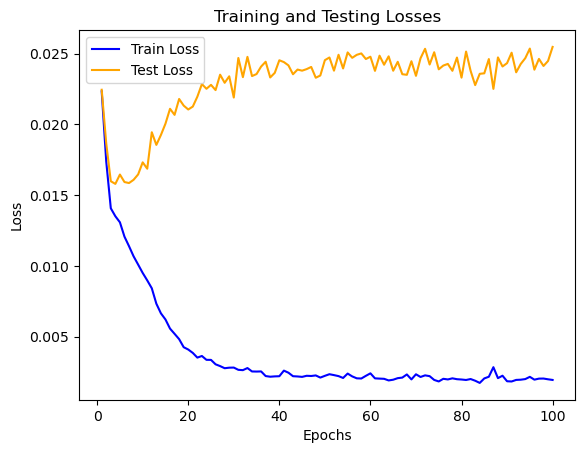

In [54]:
epochs = range(1, len(train_losses) + 1)

# Plot both training and testing losses
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.plot(epochs, test_losses, label='Test Loss', color='orange')

# Adding titles and labels
plt.title('Training and Testing Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
    
# Show the plot
plt.show()

## FDR distribution

### Training Data

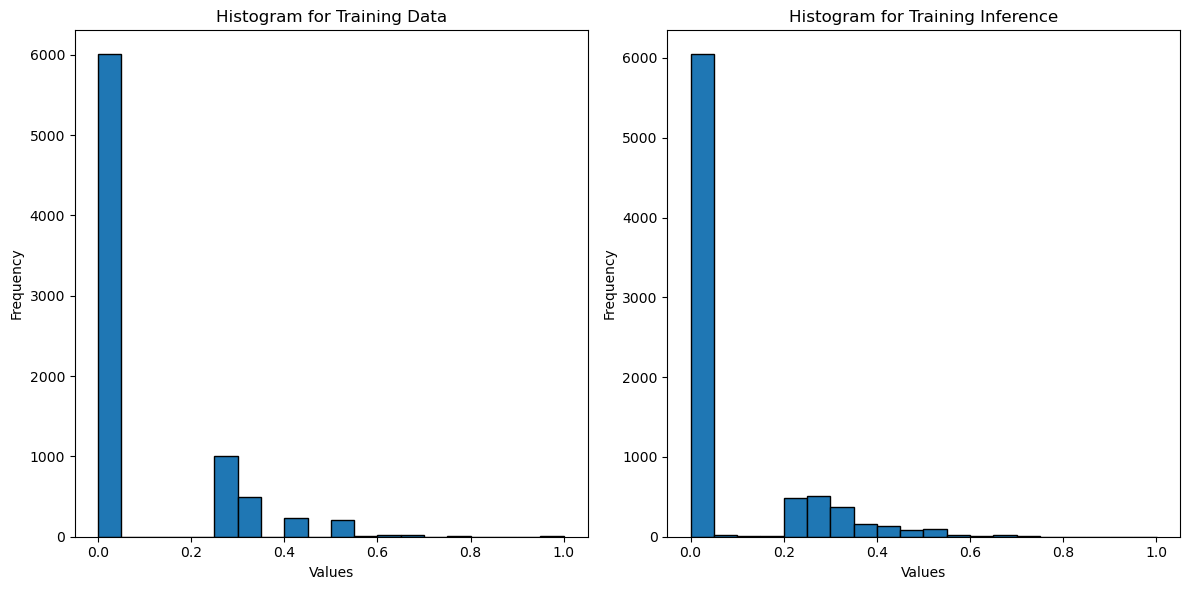

In [55]:
model.eval()

with torch.no_grad():
    train_loader_v = []
    train_infer_v = []
    for Phis, betas, vs, FDRs in train_loader:
        Phis, betas, vs, FDRs = Phis.to(device), betas.to(device), vs.to(device), FDRs.to(device)
        train_loader_v += FDRs.cpu().numpy().squeeze().tolist()
        train_infer_v += model(Phis, vs).detach().cpu().numpy().squeeze().tolist()

bin_edges = [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.3, 0.35, 0.4 , 0.45 , 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.001]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

N, bins, patches = ax1.hist(train_loader_v, bins=bin_edges, edgecolor='black')
ax1.set_title('Histogram for Training Data')
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')

N, bins, patches = ax2.hist(train_infer_v, bins=bin_edges, edgecolor='black')
ax2.set_title('Histogram for Training Inference')
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

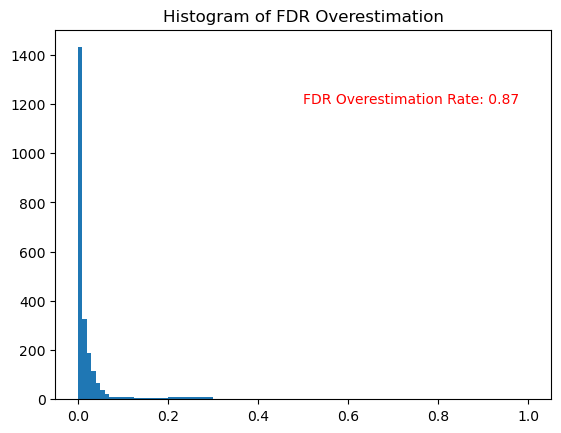

In [93]:
FDR_diff = np.array(train_infer_v) - np.array(train_loader_v)
FDR_overestimation = FDR_diff[FDR_diff > 0]
FDR_overestimation_rate = len(FDR_overestimation) / len(FDR_diff)

bin_edges = [0.0001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08 , 0.09 , 0.125, 0.15, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.001]
plt.hist(FDR_overestimation, bins=bin_edges)
plt.title("Histogram of FDR Overestimation")

# Add FDR overestimation rate as text
plt.text(0.5, plt.ylim()[1] * 0.8, f"FDR Overestimation Rate: {FDR_overestimation_rate:.2f}", fontsize=10, color='red')

# Show the plot
plt.show()

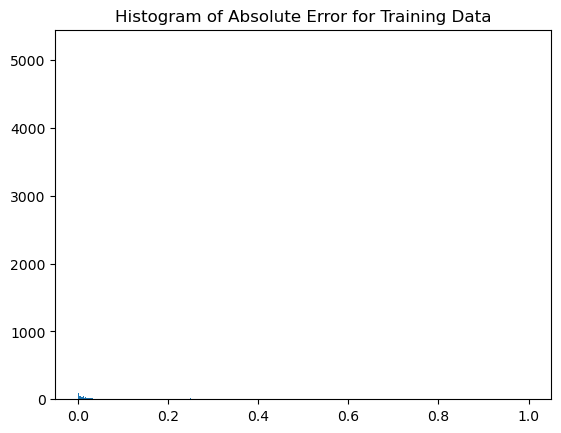

In [62]:
plt.hist(np.abs(np.array(train_loader_v) - np.array(train_infer_v)), bins='auto')
plt.title("Histogram of Absolute Error for Training Data")
plt.show()

### Test Data

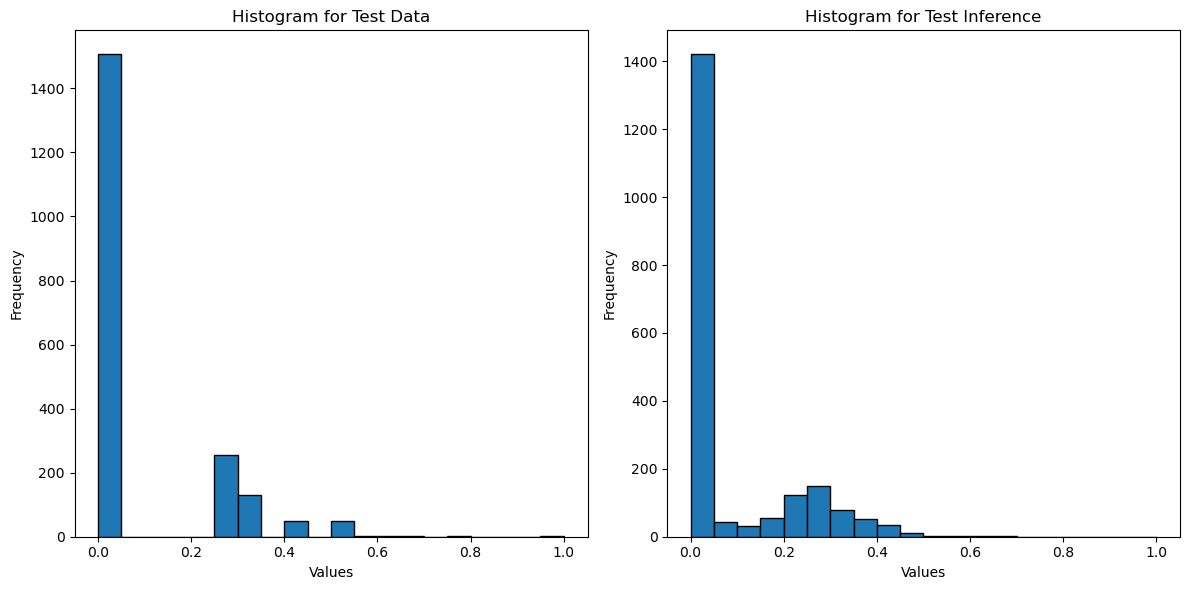

In [63]:
model.eval()

with torch.no_grad():
    test_loader_v = []
    test_infer_v = []
    for Phis, betas, vs, FDRs in test_loader:
        Phis, betas, vs, FDRs = Phis.to(device), betas.to(device), vs.to(device), FDRs.to(device)
        test_loader_v += FDRs.cpu().numpy().squeeze().tolist()
        test_infer_v += model(Phis, vs).detach().cpu().numpy().squeeze().tolist()

bin_edges = [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.3, 0.35, 0.4 , 0.45 , 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.001]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

N, bins, patches = ax1.hist(test_loader_v, bins=bin_edges, edgecolor='black')
ax1.set_title('Histogram for Test Data')
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')

N, bins, patches = ax2.hist(test_infer_v, bins=bin_edges, edgecolor='black')
ax2.set_title('Histogram for Test Inference')
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

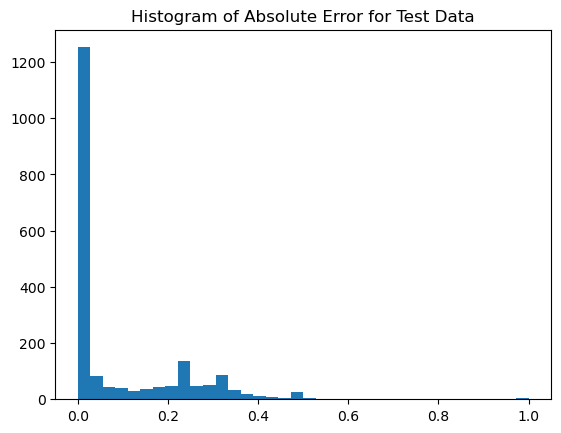

In [64]:
plt.hist(np.abs(np.array(test_loader_v) - np.array(test_infer_v)), bins='auto')
plt.title("Histogram of Absolute Error for Test Data")
plt.show()